In [2]:
import rdflib
from tqdm import tqdm
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analyze_graph(data, kg_type): 
  #Given a loaded Knowledge Graph and the source of the knowledge graph as kg_type, return some statistics

  assert data in ['movielens', 'lastfm']
  assert kg_type in ['DBpedia', 'Wikidata']

  # Load Graph
  graph = rdflib.Graph()
  graph = graph.parse(f"./{data}/2hops{kg_type}NoLiterals.nt", format = "nt")
  
  # Get a dict containing the number of relations per entity
  relations_per_entity = get_relation_freq_per_entity(graph)
  relations_per_entity_sorted = sorted(relations_per_entity.items(), key=lambda kv: kv[1])

  # Create an RDFlib Graph with the HDT document as a backend
  entities = set()
  relations = set()
  if kg_type == "DBpedia":
    for s,p,o in tqdm(graph.triples((None, None, None)), total = len(graph)):
      entities.add(s)
      if isinstance(o, rdflib.term.URIRef):
        if o.startswith("http://dbpedia.org/resource/"):
          entities.add(o)
          relations.add(p)

  elif kg_type == "Wikidata":
    for s,p,o in tqdm(graph.triples((None, None, None)), total = len(graph)):
      entities.add(s)
      if isinstance(o, rdflib.term.URIRef):
        if o.startswith("http://www.wikidata.org/entity/Q"):
          entities.add(o)
          relations.add(p)

  n_entities = len(entities)
  n_relations = len(relations)
  n_triples = len(graph)

  print()
  print(f"Number of Entities: {n_entities:>10}")
  print(f"Number of Relations: {n_relations:>10}")
  print(f"Number of Triples: {n_triples:>10}")

  return relations_per_entity_sorted, entities, relations, n_entities, n_relations, n_triples

def get_relation_freq_per_entity(graph):
  # Given a Knowledge Graph, return a dict containing the number of relations per entity

  relations_per_entity = {}
  for s,p,o in tqdm(graph.triples((None, None, None)), total = len(graph)):
    relations_per_entity[s] = relations_per_entity.get(s, 0) + 1

  return relations_per_entity

## Analyze Bipartite Graph
### Movielens

In [ ]:
ratings = pd.read_csv(f'./movielens/ratings.dat', sep='::', header=None, index_col = None, engine='python')
mappings = pd.read_csv(f'./movielens/Mapping2DBpedia-1.2-corrected.tsv', sep='\t', header=None, engine='python')
# mappings = pd.read_csv(f'./movielens/Mapping2Wikidata-1.2-corrected.tsv', sep='\t', header=None, engine='python')

# Get all Movie IDs, that successfully contain a mapping
mapped_movie_ids = mappings[0].unique().tolist()
# Subset Rating DF, according to the Mapped Movies
ratings = ratings[ratings[1].isin(mapped_movie_ids)]
# Get Positive Ratings > 4
positive_ratings = ratings.loc[ratings[2] >= 4]

# Get numbers
n_users = len(ratings[0].unique().tolist())
n_items = len(mapped_movie_ids)
n_interactions = len(ratings)
n_positive_interactions = len(positive_ratings)

sparsity = (1.0 - (n_interactions * 1.0)/(n_users * n_items))*100

# Print Numbers
print()
print(f"Number of Users: {n_users:>10}")
print(f"Number of Items: {n_items:>10}")
print(f"Number of Interactions: {n_interactions:>10}")
print(f"Positive Interactions: {n_positive_interactions} ({n_positive_interactions/n_interactions:.4f}% of all Interactions)")
print(f"Data Sparsity: {sparsity}")

In [ ]:
len(positive_ratings[0].unique().tolist())

In [ ]:
ratings.hist(column=2)

In [ ]:
grouped = positive_ratings.groupby(0)

user_freq = np.zeros(n_users, dtype=np.int)
for user_id, (name, group) in enumerate(grouped):
    user_freq[user_id] = len(group)
    
plt.plot(user_freq, color='green')
plt.xlabel('user id'); plt.ylabel('out-degree count'); plt.title('Out degree for different user ids')

In [ ]:
grouped = positive_ratings.groupby(1)

items_freq = np.zeros(n_items, dtype=np.int)
for item_id, (name, group) in enumerate(grouped):
    items_freq[item_id] = len(group)
    
plt.plot(items_freq, color='orange')
plt.xlabel('item id'); plt.ylabel('in-degree count'); plt.title('In degree for different item ids')

### Last.fm

In [3]:
user_artist_ratings = pd.read_csv(f'./lastfm/user_artists.dat', sep='\t', index_col = None, engine='python')
#mappings = pd.read_csv(f'./lastfm/Mapping2DBpedia-1.2-corrected.tsv', sep='\t', header=None, engine='python')
mappings = pd.read_csv(f'./lastfm/Mapping2Wikidata-1.2-corrected.tsv', sep='\t', header=None, engine='python')

# Get all Movie IDs, that successfully contain a mapping
mapped_artist_ids = mappings[0].unique().tolist()
# Subset Rating DF, according to the Mapped Movies
ratings = user_artist_ratings[user_artist_ratings['artistID'].isin(mapped_artist_ids)]

# Get numbers
n_users = len(ratings['userID'].unique().tolist())
n_items = len(mapped_artist_ids)
n_interactions = len(ratings)

sparsity = (1.0 - (n_interactions * 1.0)/(n_users * n_items))*100

# Print Numbers
print()
print(f"Number of Users: {n_users:>10}")
print(f"Number of Items: {n_items:>10}")
print(f"Number of Interactions: {n_interactions:>10}")
print(f"Data Sparsity: {sparsity}")


Number of Users:       1883
Number of Items:       8790
Number of Interactions:      73129
Data Sparsity: 99.55817484383657


In [ ]:
ratings

Text(0.5, 1.0, 'Out degree for different user ids')

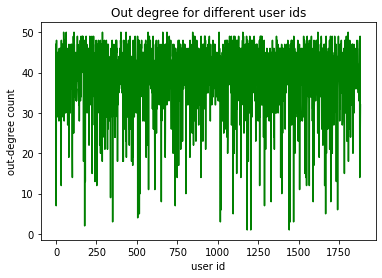

In [16]:
grouped = ratings.groupby(0)

user_freq = np.zeros(n_users, dtype=np.int)
for user_id, (name, group) in enumerate(grouped):
    user_freq[user_id] = len(group)
    
plt.plot(user_freq, color='green')
plt.xlabel('user id'); plt.ylabel('out-degree count'); plt.title('Out degree for different user ids')

Text(0.5, 1.0, 'In degree for different item ids')

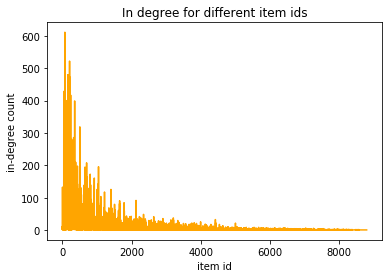

In [15]:
grouped = ratings.groupby('artistID')

items_freq = np.zeros(n_items, dtype=np.int)
for item_id, (name, group) in enumerate(grouped):
    items_freq[item_id] = len(group)
    
plt.plot(items_freq, color='orange')
plt.xlabel('item id'); plt.ylabel('in-degree count'); plt.title('In degree for different item ids')

## Analyze Knowledge Graphs
### Movielens

In [ ]:
# DBpedia
relations_per_entity_sorted, entities, relations, n_entities, n_relations, n_triples = analyze_graph(data = "movielens", kg_type = "DBpedia")

In [17]:
# Wikidata
relations_per_entity_sorted, entities, relations, n_entities, n_relations, n_triples = analyze_graph(data = "movielens", kg_type = "Wikidata")

100%|██████████| 485961/485961 [00:02<00:00, 204901.83it/s]


Number of Entities:      99767
Number of Relations:        525
Number of Triples:     485961


In [21]:
items_freq = np.zeros(n_relations, dtype=np.int)
for entity_id, (_,num_relations) in enumerate(relations_per_entity_sorted):

SyntaxError: unexpected EOF while parsing (<ipython-input-21-e9fd84566efe>, line 2)

In [20]:
len(relations_per_entity_sorted)

31274

### Wikidata

In [ ]:
# DBpedia
relations_per_entity_sorted, entities, relations, n_entities, n_relations, n_triples = analyze_graph(data = "lastfm", kg_type = "DBpedia")

In [ ]:
# Wikidata
relations_per_entity_sorted, entities, relations, n_entities, n_relations, n_triples = analyze_graph(data = "lastfm", kg_type = "Wikidata")